In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2


In [19]:
mouse = "mouse2"
df = utils.load_example_data(mouse)

In [2]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [3]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test']


In [4]:
# download the data for a specific animal
mouse = "ACV001"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list

sent 27 bytes  received 72 bytes  198.00 bytes/sec
total size is 652,361  speedup is 6,589.51


True

In [5]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

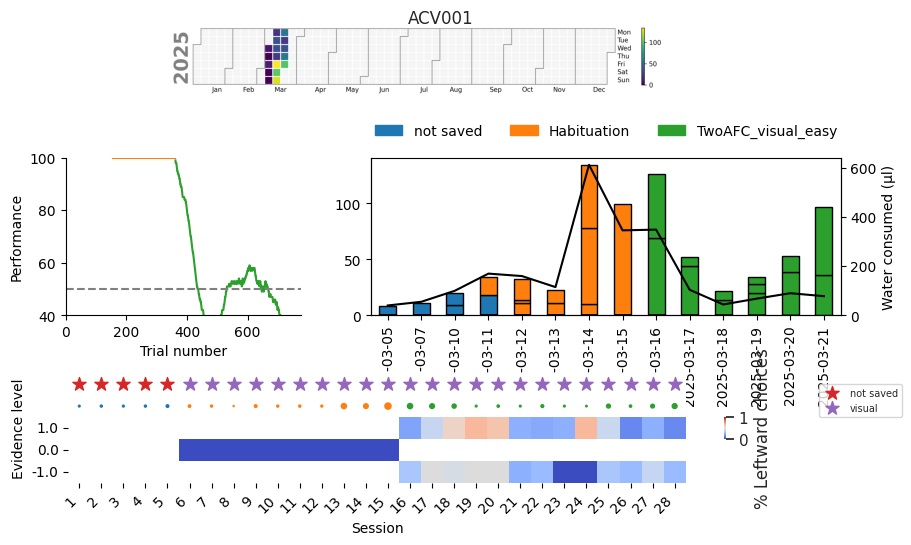

In [6]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100, summary_matrix_plot=True)


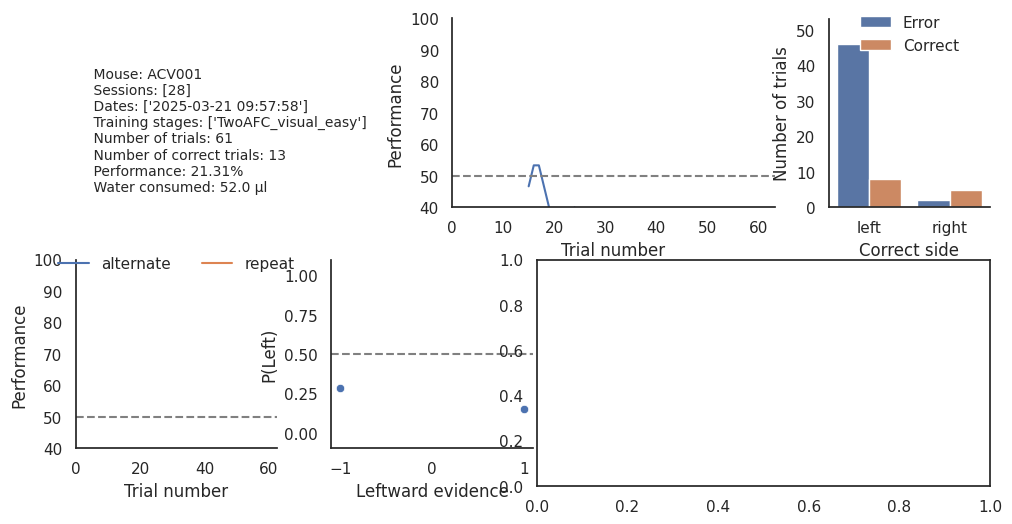

In [10]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 28
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=15, width=10, height=5)

In [ ]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
from lecilab_behavior_analysis.df_transforms import calculate_time_between_trials_and_rection_time
session = 20
df = calculate_time_between_trials_and_rection_time(df)
sdf = df[df["session"] == session].copy()
fig = plot_time_between_trials_and_reaction_time(sdf)
